In [1]:
from __future__ import print_function
import numpy as np 
import pandas as pd 
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
# import helper
import matplotlib.pyplot as plt


import IPython.display as ipd
import seaborn as sns

import warnings
import os
os.chdir("D:/DataIncubator_ChestXray/")
warnings.filterwarnings('ignore')

from torch import nn, optim
from torchvision import transforms, models, datasets

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [2]:
pwd

'D:\\DataIncubator_ChestXray'

In [3]:
data_dir = 'D:/DataIncubator_ChestXray/chest_xray'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'
model_save_path = 'D:/DataIncubator_ChestXray/model_output'

In [4]:
batch_size = 8

In [5]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
                                        transforms.RandomRotation(degrees=15),
                                        transforms.ColorJitter(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.CenterCrop(size=224),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                             [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [6]:
trainset = datasets.ImageFolder(train_dir,transform=train_transforms)
validset = datasets.ImageFolder(valid_dir,transform=val_transforms)
testset = datasets.ImageFolder(test_dir,transform=test_transforms)

In [7]:
trainset

Dataset ImageFolder
    Number of datapoints: 5216
    Root Location: D:/DataIncubator_ChestXray/chest_xray/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomRotation(degrees=(-15, 15), resample=False, expand=False)
                             ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
                             RandomHorizontalFlip(p=0.5)
                             CenterCrop(size=(224, 224))
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None

In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: index 8 is out of bounds for axis 0 with size 8

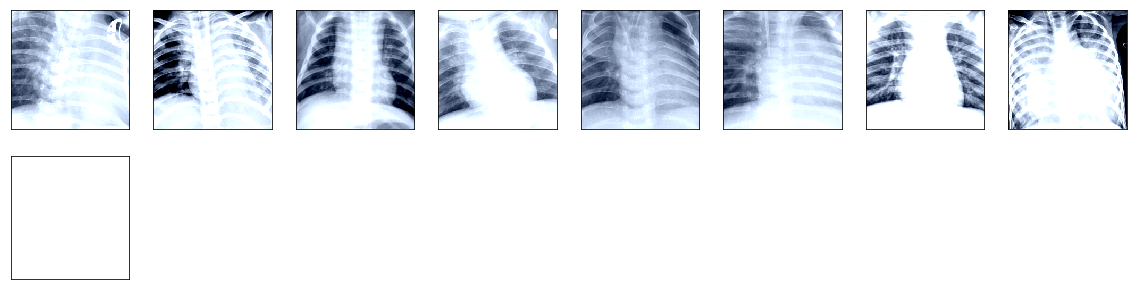

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1,2,0)));
    
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(20,5))

for idx in np.arange(9):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[]);
    imshow(images[idx]);
print(labels)

In [9]:
trainiter = iter(trainloader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [10]:
torch.cuda.is_available()

True

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
classifier = nn.Sequential(nn.Linear(2048, 512),
                           nn.ReLU(),
                          nn.Dropout(p=0.5),
                          nn.Linear(512, 2),
                          nn.LogSoftmax(dim=1))
model.fc = classifier
criterion = nn.NLLLoss()

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,558,146 total parameters.
1,050,114 training parameters.


In [16]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

)


In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model = model.to(device)

In [18]:
def train(epoch):
    model.train()
    correct_train = 0
#     history_train = []
    train_loss = 0
    train_acc = 0
    
    
    for batch_idx, (data, target) in enumerate(trainloader):
        data, target = data.to(device), target.to(device)
        
        # zero the gradient, forward, backward and running pytorch rhythm
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct_train += pred.eq(target.data.view_as(pred)).cpu().sum()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.data[0]))
    
    train_loss /= len(trainloader.dataset)
    train_acc = 100. * correct_train / len(trainloader.dataset)
    print("train accuracy {}".format(train_acc))
    print('\nTrain Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct_train, len(trainloader.dataset), 100. * correct_train / len(trainloader.dataset)))
#     history_train.append([train_loss, train_acc])
    
#     history_train_df = pd.DataFrame(history_train, columns=['train_loss', 'train_acc'])
    return train_loss, train_acc
            

In [19]:
def valid():
    model.eval()
    val_loss = 0
    correct = 0

    for data, target in validloader:
        data, target = data.to(device), target.to(device)
        
        # output from model
        output = model(data)
        
        # sum total loss
        val_loss += criterion(output, target).data[0]
        
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    val_loss /= len(validloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validloader.dataset),
        100. * correct / len(validloader.dataset)))

In [20]:
def test():
    model.eval()
    test_loss = 0
    test_acc = 0
    correct = 0
    history_test = []

    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        
        # output from model
        output = model(data)
        
        # sum total loss
        test_loss += criterion(output, target).data[0]
        
        # get the label of prediction
        pred = torch.max(output.data, 1)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    test_loss /= len(testloader.dataset)
    test_acc = 100. * correct / len(testloader.dataset)
    print("test accuracy {}".format(test_acc))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))
    
#     history_test.append([test_loss, test_acc])
    
#     history_test_df = history_test_df.append(pd.DataFrame(history_test, index=['test_loss', 'test_acc']), ignore_index=True)
    return test_loss, test_acc

In [21]:
history = []
for epoch in range(1, 11):
    exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch)
    
    test_loss, test_acc = test()
    
    history.append([train_loss, train_acc, test_loss, test_acc])

Train Epoch: 1 [0/5216 (0%)]	Loss: 0.702507

Train Epoch: 1 [80/5216 (2%)]	Loss: 5.560554

Train Epoch: 1 [160/5216 (3%)]	Loss: 1.513894

Train Epoch: 1 [240/5216 (5%)]	Loss: 1.667220

Train Epoch: 1 [320/5216 (6%)]	Loss: 0.760194

Train Epoch: 1 [400/5216 (8%)]	Loss: 0.473804

Train Epoch: 1 [480/5216 (9%)]	Loss: 1.059117

Train Epoch: 1 [560/5216 (11%)]	Loss: 0.917951

Train Epoch: 1 [640/5216 (12%)]	Loss: 0.120429

Train Epoch: 1 [720/5216 (14%)]	Loss: 0.138420

Train Epoch: 1 [800/5216 (15%)]	Loss: 0.613541

Train Epoch: 1 [880/5216 (17%)]	Loss: 0.785745

Train Epoch: 1 [960/5216 (18%)]	Loss: 0.102099

Train Epoch: 1 [1040/5216 (20%)]	Loss: 0.267044

Train Epoch: 1 [1120/5216 (21%)]	Loss: 0.232442

Train Epoch: 1 [1200/5216 (23%)]	Loss: 0.321335

Train Epoch: 1 [1280/5216 (25%)]	Loss: 0.140219

Train Epoch: 1 [1360/5216 (26%)]	Loss: 0.021103

Train Epoch: 1 [1440/5216 (28%)]	Loss: 0.450496

Train Epoch: 1 [1520/5216 (29%)]	Loss: 0.138617

Train Epoch: 1 [1600/5216 (31%)]	Loss: 1.39


Train Epoch: 3 [2560/5216 (49%)]	Loss: 0.417742

Train Epoch: 3 [2640/5216 (51%)]	Loss: 0.670194

Train Epoch: 3 [2720/5216 (52%)]	Loss: 0.178638

Train Epoch: 3 [2800/5216 (54%)]	Loss: 0.836604

Train Epoch: 3 [2880/5216 (55%)]	Loss: 0.018627

Train Epoch: 3 [2960/5216 (57%)]	Loss: 0.249655

Train Epoch: 3 [3040/5216 (58%)]	Loss: 0.257371

Train Epoch: 3 [3120/5216 (60%)]	Loss: 0.237115

Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.160166

Train Epoch: 3 [3280/5216 (63%)]	Loss: 0.141208

Train Epoch: 3 [3360/5216 (64%)]	Loss: 0.767728

Train Epoch: 3 [3440/5216 (66%)]	Loss: 0.185699

Train Epoch: 3 [3520/5216 (67%)]	Loss: 0.645209

Train Epoch: 3 [3600/5216 (69%)]	Loss: 0.470712

Train Epoch: 3 [3680/5216 (71%)]	Loss: 0.141750

Train Epoch: 3 [3760/5216 (72%)]	Loss: 0.490015

Train Epoch: 3 [3840/5216 (74%)]	Loss: 0.350918

Train Epoch: 3 [3920/5216 (75%)]	Loss: 0.724628

Train Epoch: 3 [4000/5216 (77%)]	Loss: 0.194879

Train Epoch: 3 [4080/5216 (78%)]	Loss: 0.326284

Train Epoch: 3 [416


Train Epoch: 5 [5040/5216 (97%)]	Loss: 0.454981

Train Epoch: 5 [5120/5216 (98%)]	Loss: 0.192018

Train Epoch: 5 [5200/5216 (100%)]	Loss: 0.090321

train accuracy 88

Train Accuracy: 4600/5216 (88%)

test accuracy 82

Test set: Average loss: 0.0646, Accuracy: 516/624 (82%)

Train Epoch: 6 [0/5216 (0%)]	Loss: 0.248682

Train Epoch: 6 [80/5216 (2%)]	Loss: 0.197530

Train Epoch: 6 [160/5216 (3%)]	Loss: 0.900186

Train Epoch: 6 [240/5216 (5%)]	Loss: 0.219385

Train Epoch: 6 [320/5216 (6%)]	Loss: 0.161363

Train Epoch: 6 [400/5216 (8%)]	Loss: 0.575096

Train Epoch: 6 [480/5216 (9%)]	Loss: 0.389990

Train Epoch: 6 [560/5216 (11%)]	Loss: 0.692088

Train Epoch: 6 [640/5216 (12%)]	Loss: 0.384946

Train Epoch: 6 [720/5216 (14%)]	Loss: 0.298489

Train Epoch: 6 [800/5216 (15%)]	Loss: 0.276189

Train Epoch: 6 [880/5216 (17%)]	Loss: 0.081554

Train Epoch: 6 [960/5216 (18%)]	Loss: 0.011632

Train Epoch: 6 [1040/5216 (20%)]	Loss: 0.158347

Train Epoch: 6 [1120/5216 (21%)]	Loss: 0.075103

Train Epoch:


Train Epoch: 8 [2080/5216 (40%)]	Loss: 0.080360

Train Epoch: 8 [2160/5216 (41%)]	Loss: 0.304554

Train Epoch: 8 [2240/5216 (43%)]	Loss: 0.295425

Train Epoch: 8 [2320/5216 (44%)]	Loss: 0.059177

Train Epoch: 8 [2400/5216 (46%)]	Loss: 0.301974

Train Epoch: 8 [2480/5216 (48%)]	Loss: 0.118839

Train Epoch: 8 [2560/5216 (49%)]	Loss: 0.118955

Train Epoch: 8 [2640/5216 (51%)]	Loss: 0.322290

Train Epoch: 8 [2720/5216 (52%)]	Loss: 0.229742

Train Epoch: 8 [2800/5216 (54%)]	Loss: 0.338788

Train Epoch: 8 [2880/5216 (55%)]	Loss: 0.424953

Train Epoch: 8 [2960/5216 (57%)]	Loss: 0.073159

Train Epoch: 8 [3040/5216 (58%)]	Loss: 0.152067

Train Epoch: 8 [3120/5216 (60%)]	Loss: 0.192769

Train Epoch: 8 [3200/5216 (61%)]	Loss: 0.190117

Train Epoch: 8 [3280/5216 (63%)]	Loss: 0.283177

Train Epoch: 8 [3360/5216 (64%)]	Loss: 0.266524

Train Epoch: 8 [3440/5216 (66%)]	Loss: 0.284445

Train Epoch: 8 [3520/5216 (67%)]	Loss: 0.221867

Train Epoch: 8 [3600/5216 (69%)]	Loss: 0.207660

Train Epoch: 8 [368


Train Epoch: 10 [4480/5216 (86%)]	Loss: 0.126139

Train Epoch: 10 [4560/5216 (87%)]	Loss: 0.168105

Train Epoch: 10 [4640/5216 (89%)]	Loss: 0.339061

Train Epoch: 10 [4720/5216 (90%)]	Loss: 0.244482

Train Epoch: 10 [4800/5216 (92%)]	Loss: 0.240906

Train Epoch: 10 [4880/5216 (94%)]	Loss: 0.449789

Train Epoch: 10 [4960/5216 (95%)]	Loss: 0.164109

Train Epoch: 10 [5040/5216 (97%)]	Loss: 0.311080

Train Epoch: 10 [5120/5216 (98%)]	Loss: 0.205600

Train Epoch: 10 [5200/5216 (100%)]	Loss: 0.357436

train accuracy 90

Train Accuracy: 4696/5216 (90%)

test accuracy 79

Test set: Average loss: 0.0830, Accuracy: 493/624 (79%)



In [21]:
history

[[tensor(0.0502, device='cuda:0'),
  tensor(83),
  tensor(0.0461, device='cuda:0'),
  tensor(84)],
 [tensor(0.0430, device='cuda:0'),
  tensor(82),
  tensor(0.0696, device='cuda:0'),
  tensor(80)],
 [tensor(0.0402, device='cuda:0'),
  tensor(84),
  tensor(0.0771, device='cuda:0'),
  tensor(77)],
 [tensor(0.0386, device='cuda:0'),
  tensor(86),
  tensor(0.0884, device='cuda:0'),
  tensor(77)],
 [tensor(0.0372, device='cuda:0'),
  tensor(87),
  tensor(0.0516, device='cuda:0'),
  tensor(87)],
 [tensor(0.0375, device='cuda:0'),
  tensor(86),
  tensor(0.0711, device='cuda:0'),
  tensor(80)],
 [tensor(0.0386, device='cuda:0'),
  tensor(86),
  tensor(0.1124, device='cuda:0'),
  tensor(74)],
 [tensor(0.0362, device='cuda:0'),
  tensor(86),
  tensor(0.0634, device='cuda:0'),
  tensor(81)],
 [tensor(0.0367, device='cuda:0'),
  tensor(87),
  tensor(0.0626, device='cuda:0'),
  tensor(82)],
 [tensor(0.0358, device='cuda:0'),
  tensor(87),
  tensor(0.0810, device='cuda:0'),
  tensor(80)]]

In [22]:
history_transformed = []
for i in range(len(history)):
    history_transformed.append([x.tolist() for x in history[i]])


In [23]:
history_df = pd.DataFrame(history_transformed, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [24]:
history_df["epoch"] = [x for x in range(1, 11)]

In [25]:
history_df

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.052031,84,0.061989,78,1
1,0.039910,84,0.056627,79,2
2,0.039885,86,0.052355,79,3
3,0.038667,86,0.081687,76,4
4,0.032986,88,0.064637,82,5
5,0.031679,89,0.077481,80,6
6,0.032348,89,0.070899,81,7
7,0.033134,89,0.080776,78,8
8,0.032321,89,0.075521,79,9
9,0.030785,90,0.082952,79,10


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

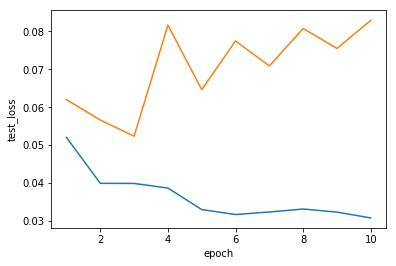

In [27]:
sns.lineplot(x='epoch', y='train_loss', data=history_df)
sns.lineplot(x='epoch', y='test_loss', data=history_df)
# plt.xticks()

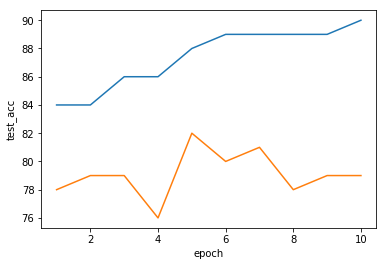

In [28]:
sns.lineplot(x='epoch', y='train_acc', data=history_df)
sns.lineplot(x='epoch', y='test_acc', data=history_df)

In [29]:
torch.save(model, model_save_path + '/ResNet50_Freeze.pth')

In [30]:
for param in model.parameters():
    param.requires_grad = True

In [31]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [32]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

24,558,146 total parameters.
24,558,146 training parameters.


In [33]:
model = model.to(device)

In [34]:
history_unfreeze = []
for epoch in range(1, 5):
    exp_lr_scheduler.step(epoch)
    
    train_loss, train_acc = train(epoch)
    
    test_loss, test_acc = test()
    
    history_unfreeze.append([train_loss, train_acc, test_loss, test_acc])

Train Epoch: 1 [0/5216 (0%)]	Loss: 0.311163

Train Epoch: 1 [80/5216 (2%)]	Loss: 0.396935

Train Epoch: 1 [160/5216 (3%)]	Loss: 0.729326

Train Epoch: 1 [240/5216 (5%)]	Loss: 0.414249

Train Epoch: 1 [320/5216 (6%)]	Loss: 0.195654

Train Epoch: 1 [400/5216 (8%)]	Loss: 0.742481

Train Epoch: 1 [480/5216 (9%)]	Loss: 0.367293

Train Epoch: 1 [560/5216 (11%)]	Loss: 0.523750

Train Epoch: 1 [640/5216 (12%)]	Loss: 0.341924

Train Epoch: 1 [720/5216 (14%)]	Loss: 0.290623

Train Epoch: 1 [800/5216 (15%)]	Loss: 0.176866

Train Epoch: 1 [880/5216 (17%)]	Loss: 1.309518

Train Epoch: 1 [960/5216 (18%)]	Loss: 0.291176

Train Epoch: 1 [1040/5216 (20%)]	Loss: 0.088519

Train Epoch: 1 [1120/5216 (21%)]	Loss: 0.661717

Train Epoch: 1 [1200/5216 (23%)]	Loss: 0.431037

Train Epoch: 1 [1280/5216 (25%)]	Loss: 0.457735

Train Epoch: 1 [1360/5216 (26%)]	Loss: 0.168828

Train Epoch: 1 [1440/5216 (28%)]	Loss: 0.759366

Train Epoch: 1 [1520/5216 (29%)]	Loss: 0.265974

Train Epoch: 1 [1600/5216 (31%)]	Loss: 0.36


Train Epoch: 3 [2560/5216 (49%)]	Loss: 0.175877

Train Epoch: 3 [2640/5216 (51%)]	Loss: 0.546607

Train Epoch: 3 [2720/5216 (52%)]	Loss: 0.071123

Train Epoch: 3 [2800/5216 (54%)]	Loss: 0.287282

Train Epoch: 3 [2880/5216 (55%)]	Loss: 0.246906

Train Epoch: 3 [2960/5216 (57%)]	Loss: 0.538987

Train Epoch: 3 [3040/5216 (58%)]	Loss: 0.238955

Train Epoch: 3 [3120/5216 (60%)]	Loss: 0.201772

Train Epoch: 3 [3200/5216 (61%)]	Loss: 0.356706

Train Epoch: 3 [3280/5216 (63%)]	Loss: 0.814252

Train Epoch: 3 [3360/5216 (64%)]	Loss: 0.339123

Train Epoch: 3 [3440/5216 (66%)]	Loss: 0.174287

Train Epoch: 3 [3520/5216 (67%)]	Loss: 0.179477

Train Epoch: 3 [3600/5216 (69%)]	Loss: 0.300164

Train Epoch: 3 [3680/5216 (71%)]	Loss: 0.150947

Train Epoch: 3 [3760/5216 (72%)]	Loss: 0.292068

Train Epoch: 3 [3840/5216 (74%)]	Loss: 0.290164

Train Epoch: 3 [3920/5216 (75%)]	Loss: 0.126340

Train Epoch: 3 [4000/5216 (77%)]	Loss: 0.579010

Train Epoch: 3 [4080/5216 (78%)]	Loss: 0.441132

Train Epoch: 3 [416

In [35]:
history_transformed_unfrz = []
for i in range(len(history_unfreeze)):
    history_transformed_unfrz.append([x.tolist() for x in history_unfreeze[i]])


In [36]:
history_df_unfrz = pd.DataFrame(history_transformed_unfrz, columns=["train_loss", "train_acc", "test_loss", "test_acc"])

In [37]:
history_df_unfrz["epoch"] = [x for x in range(11, 15)]

In [38]:
history_df_unfrz

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.052819,82,0.048830,83,11
1,0.039267,87,0.069182,84,12
2,0.036927,86,0.063878,83,13
3,0.037797,88,0.077114,82,14


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

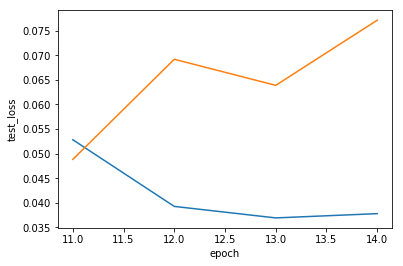

In [40]:
sns.lineplot(x='epoch', y='train_loss', data=history_df_unfrz)
sns.lineplot(x='epoch', y='test_loss', data=history_df_unfrz)
# plt.xticks()

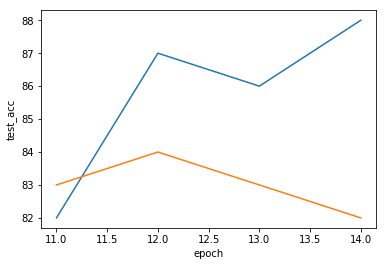

In [41]:
sns.lineplot(x='epoch', y='train_acc', data=history_df_unfrz)
sns.lineplot(x='epoch', y='test_acc', data=history_df_unfrz)

In [42]:
torch.save(model, model_save_path + '/ResNet50_UnFreeze.pth')

In [43]:
history_total = pd.concat([history_df, history_df_unfrz])

In [44]:
history_total

,train_loss,train_acc,test_loss,test_acc,epoch
0,0.052031,84,0.061989,78,1
1,0.039910,84,0.056627,79,2
2,0.039885,86,0.052355,79,3
3,0.038667,86,0.081687,76,4
4,0.032986,88,0.064637,82,5
5,0.031679,89,0.077481,80,6
6,0.032348,89,0.070899,81,7
7,0.033134,89,0.080776,78,8
8,0.032321,89,0.075521,79,9
9,0.030785,90,0.082952,79,10


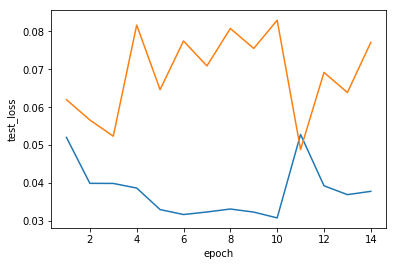

In [45]:
sns.lineplot(x='epoch', y='train_loss', data=history_total)
sns.lineplot(x='epoch', y='test_loss', data=history_total)

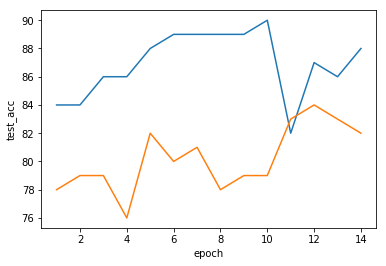

In [46]:
sns.lineplot(x='epoch', y='train_acc', data=history_total)
sns.lineplot(x='epoch', y='test_acc', data=history_total)